In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from pathlib import Path


In [2]:
# Ruta base de los datos
base_path = Path("../../data/raw/Open_Meteo/diarios/Barcelona_data")
print("Ruta absoluta:", base_path.resolve())

# Lista para almacenar DataFrames individuales
dfs = []

for entry in base_path.glob("*"):
    print(f"[DEBUG] Elemento encontrado: {entry.name} (¿Es directorio? {entry.is_dir()})")
    
    if entry.is_dir() and entry.name.isdigit():  # Filtra solo directorios con nombres numéricos (años)
        year = int(entry.name)
        print(f"[DEBUG] Procesando año: {year}")
        
        # Iterar sobre los meses dentro del año
        for month_dir in entry.glob("*"):
            if month_dir.is_dir():
                print(f"[DEBUG] Procesando mes: {month_dir.name}")
                
                # Leer todos los CSV del mes
                for csv_file in month_dir.glob("*.csv"):
                    print(f"[DEBUG] Leyendo archivo: {csv_file}")
                    try:
                        df = pd.read_csv(csv_file, parse_dates=["date"]) 
                        dfs.append(df)
                    except Exception as e:
                        print(f"[ERROR] Fallo al leer {csv_file}: {e}")

if not dfs:
    print("[ERROR] No se cargaron datos. Verifica:")
    print("1. La estructura de carpetas: Barcelona_data/diarios/AAAA/MM/AAAA-MM-DD.csv")
    print("2. Que los archivos CSV tengan la columna 'fecha'")
else:
    df = pd.concat(dfs, ignore_index=True)
    #df.sort_values("date", inplace=True)

Ruta absoluta: C:\Users\JWinn01\Desktop\IABD\Proyecto3\PrediccionMeteorologica\data\raw\Open_Meteo\diarios\Barcelona_data
[DEBUG] Elemento encontrado: 2020 (¿Es directorio? True)
[DEBUG] Procesando año: 2020
[DEBUG] Procesando mes: 03
[DEBUG] Leyendo archivo: ..\..\data\raw\Open_Meteo\diarios\Barcelona_data\2020\03\2020-03-02.csv
[DEBUG] Leyendo archivo: ..\..\data\raw\Open_Meteo\diarios\Barcelona_data\2020\03\2020-03-03.csv
[DEBUG] Leyendo archivo: ..\..\data\raw\Open_Meteo\diarios\Barcelona_data\2020\03\2020-03-04.csv
[DEBUG] Leyendo archivo: ..\..\data\raw\Open_Meteo\diarios\Barcelona_data\2020\03\2020-03-05.csv
[DEBUG] Leyendo archivo: ..\..\data\raw\Open_Meteo\diarios\Barcelona_data\2020\03\2020-03-06.csv
[DEBUG] Leyendo archivo: ..\..\data\raw\Open_Meteo\diarios\Barcelona_data\2020\03\2020-03-07.csv
[DEBUG] Leyendo archivo: ..\..\data\raw\Open_Meteo\diarios\Barcelona_data\2020\03\2020-03-08.csv
[DEBUG] Leyendo archivo: ..\..\data\raw\Open_Meteo\diarios\Barcelona_data\2020\03\2020

In [3]:
df.head(5)

,date,temperature_2m,relative_humidity_2m
0,2020-03-02 00:00:00,8.581,95.686676
1,2020-03-02 01:00:00,7.731,89.302870
2,2020-03-02 02:00:00,7.481,91.467070
3,2020-03-02 03:00:00,7.631,94.675840
4,2020-03-02 04:00:00,7.931,93.399890


In [4]:
print(df["temperature_2m"]>0.0)

0        True
1        True
2        True
3        True
4        True
         ... 
43843    True
43844    True
43845    True
43846    True
43847    True
Name: temperature_2m, Length: 43848, dtype: bool


In [ ]:
df = df.set_index('date').asfreq('H')  # Frecuencia horaria
#df = df[['temperature_2m']]
df = df[['temperature_2m', 'relative_humidity_2m']]

C:\Users\JWinn01\AppData\Local\Temp\ipykernel_19092\2282749607.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.set_index('date').asfreq('H')  # Frecuencia horaria


KeyError: "['precipitation'] not in index"

In [ ]:

#forecasts

NameError: name 'forecasts' is not defined

In [ ]:
# 2. Manejar valores faltantes
df = df.interpolate(method='time')
from statsmodels.tsa.arima.model import ARIMA
# 3. Dividir datos (últimas 24 horas)
train = df.iloc[:-24]
test = df.iloc[-24:]

# 4. Función para ajustar modelo SARIMAX con parámetros limitados
def fit_sarimax(endog):
    model = auto_arima(
        endog,
        seasonal=False,  # Quitar estacionalidad
        order=(1, 1, 1), # Parámetros más simples
        trace=True
    )
    return model

def fit_quick_model(endog):
    model = ARIMA(endog, order=(0,1,1)).fit()  # Modelo fijo simple
    return model

# 5. Entrenar modelos para cada variable
models = {}
for col in df.columns:
    print(f"\n=== Modelo para {col} ===")
    models[col] = fit_sarimax(train[col])
    print(models[col])

# 6. Predicciones para 24 horas
forecasts = pd.DataFrame(index=pd.date_range(start=test.index[0], periods=24, freq='H'))

for col, model in models.items():
    forecasts[col] = model.predict(n_periods=24)
    print(forecasts[col])

# 7. Visualización
plt.figure(figsize=(15, 10))

start_date = train.index[-72]  # 3 días antes del test
end_date = test.index[-1]

plt.figure(figsize=(15, 10))

# Temperatura ----
plt.subplot(3,1,1)
# Mostrar solo últimos 3 días de entrenamiento
plt.plot(train['temperature_2m'].last('3D'), label='Entrenamiento', alpha=0.8)
# Test y predicción completos
plt.plot(test['temperature_2m'], label='Real', color='green', linewidth=2)
plt.plot(forecasts['temperature_2m'], label='Predicción', color='red', linestyle='--')
plt.title('Predicción de Temperatura - Últimas 72h + Pronóstico')
plt.xlim(start_date, end_date)  # Fijar límites temporales
plt.legend()
plt.grid(True, alpha=0.3)

# Humedad ----
plt.subplot(3,1,2)
plt.plot(train['relative_humidity_2m'].last('3D'), label='Entrenamiento', alpha=0.8)
plt.plot(test['relative_humidity_2m'], label='Real', color='green', linewidth=2)
plt.plot(forecasts['relative_humidity_2m'], label='Predicción', color='red', linestyle='--')
plt.title('Humedad Relativa - Últimas 72h + Pronóstico')
plt.xlim(start_date, end_date)
plt.legend()
plt.grid(True, alpha=0.3)

# Precipitación ----
plt.subplot(3,1,3)
plt.plot(train['precipitation'].last('3D'), label='Entrenamiento', alpha=0.8)
plt.plot(test['precipitation'], label='Real', color='green', linewidth=2)
plt.plot(forecasts['precipitation'], label='Predicción', color='red', linestyle='--')
plt.title('Precipitación - Últimas 72h + Pronóstico')
plt.xlim(start_date, end_date)
plt.legend()
plt.grid(True, alpha=0.3)

# Formateo común
plt.tight_layout()
plt.xticks(rotation=45)  # Rotar fechas para mejor visualización
plt.show()


# 8. Métricas de evaluación
from sklearn.metrics import mean_absolute_error

for col in df.columns:
    mae = mean_absolute_error(test[col], forecasts[col])
    print(f'MAE para {col}: {mae:.2f}')


=== Modelo para temperature_2m ===
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=104665.124, Time=34.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=133148.919, Time=0.54 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=112953.363, Time=1.42 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=119700.786, Time=2.76 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=133146.920, Time=0.41 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=112386.915, Time=5.71 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=112420.888, Time=6.39 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=101258.003, Time=48.35 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=112406.380, Time=15.34 sec


In [ ]:
# Ruta base de los datos
base_path = Path("../../data/raw/Open_Meteo/daily/Barcelona")
print("Ruta absoluta:", base_path.resolve())

# Lista para almacenar DataFrames individuales
dfs = []

for year_dir in base_path.iterdir():
    if year_dir.is_dir() and year_dir.name.isdigit():
        print(f"[DEBUG] Procesando año: {year_dir.name}")
        
        # Buscar todos los archivos CSV en el directorio del año
        for csv_file in year_dir.glob("*.csv"):
            print(f"[DEBUG] Leyendo archivo: {csv_file}")
            
            try:
                # Leer CSV con formato de fecha correcto
                df = pd.read_csv(csv_file, parse_dates=['date'])
                dfs.append(df)
            except Exception as e:
                print(f"[ERROR] Fallo al leer {csv_file}: {str(e)}")
                continue

# Consolidar datos
if dfs:
    df = pd.concat(dfs, ignore_index=True)
    df.sort_values('date', inplace=True)
    print("\nDatos cargados exitosamente!")
    print(f"Total de registros: {len(df)}")
    print(f"Rango temporal: {df['date'].min()} - {df['date'].max()}")
else:
    print("[ERROR] No se encontraron archivos CSV válidos. Verifica:")
    print("1. La estructura de carpetas: Barcelona/AAAA/*.csv")
    print("2. Que los CSV contengan columna 'date'")
    #df = pd.concat(dfs, ignore_index=True)
    #df.sort_values("date", inplace=True)

Ruta absoluta: C:\Users\JWinn01\Desktop\IABD\Proyectos_IABD\PrediccionMeteorologica\data\raw\Open-Meteo_datos\daily\Barcelona
[DEBUG] Procesando año: 2022
[DEBUG] Leyendo archivo: ..\..\data\raw\Open-Meteo_datos\daily\Barcelona\2022\Abril_meteo.csv
[DEBUG] Leyendo archivo: ..\..\data\raw\Open-Meteo_datos\daily\Barcelona\2022\Agosto_meteo.csv
[DEBUG] Leyendo archivo: ..\..\data\raw\Open-Meteo_datos\daily\Barcelona\2022\Diciembre_meteo.csv
[DEBUG] Leyendo archivo: ..\..\data\raw\Open-Meteo_datos\daily\Barcelona\2022\Febrero_meteo.csv
[DEBUG] Leyendo archivo: ..\..\data\raw\Open-Meteo_datos\daily\Barcelona\2022\Julio_meteo.csv
[DEBUG] Leyendo archivo: ..\..\data\raw\Open-Meteo_datos\daily\Barcelona\2022\Junio_meteo.csv
[DEBUG] Leyendo archivo: ..\..\data\raw\Open-Meteo_datos\daily\Barcelona\2022\Marzo_meteo.csv
[DEBUG] Leyendo archivo: ..\..\data\raw\Open-Meteo_datos\daily\Barcelona\2022\Mayo_meteo.csv
[DEBUG] Leyendo archivo: ..\..\data\raw\Open-Meteo_datos\daily\Barcelona\2022\Noviembre

In [ ]:
df = df.set_index('date').asfreq('D')
#df = df[['temperature_2m']]
df = df[['temperature_2m_mean', 'apparent_temperature_mean', 'sunrise']]
df

,temperature_2m_mean,apparent_temperature_mean,sunrise
date,,,
2022-02-20 00:00:00+00:00,8.915000,6.285871,0
2022-02-21 00:00:00+00:00,11.344167,8.731029,0
2022-02-22 00:00:00+00:00,10.496250,8.017712,0
2022-02-23 00:00:00+00:00,10.008751,8.001440,0
2022-02-24 00:00:00+00:00,11.506668,9.892905,0
...,...,...,...
2025-02-16 00:00:00+00:00,10.381666,9.290269,0
2025-02-17 00:00:00+00:00,10.773334,9.735724,0
2025-02-18 00:00:00+00:00,11.223332,10.554162,0


In [ ]:
forecasts
test.index[6]

Timestamp('2025-02-20 00:00:00+0000', tz='UTC')


=== Modelo para temperature_2m_mean ===
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3877.322, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3876.397, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3875.649, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3875.324, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3826.789, Time=0.26 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3821.446, Time=0.45 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3867.962, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3821.475, Time=0.36 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.13 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3862.140, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3819.446, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3824.789, Time=0.11 sec
 ARIMA(

C:\Users\JWinn01\AppData\Roaming\Python\Python311\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\JWinn01\AppData\Local\Temp\ipykernel_3632\1974215616.py:47: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  plt.plot(train['temperature_2m_mean'].last('21D'), label='Entrenamiento', alpha=0.8)
C:\Users\JWinn01\AppData\Local\Temp\ipykernel_3632\1974215616.py:58: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  plt.plot(train['apparent_temperature_mean'].last('21D'), label='Entrenamiento', alpha=0.8)
C:\Users\JWinn01\AppData\Local\Temp\ipykernel_3632\1974215616.py:68: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` i

<Figure size 1500x1000 with 0 Axes>

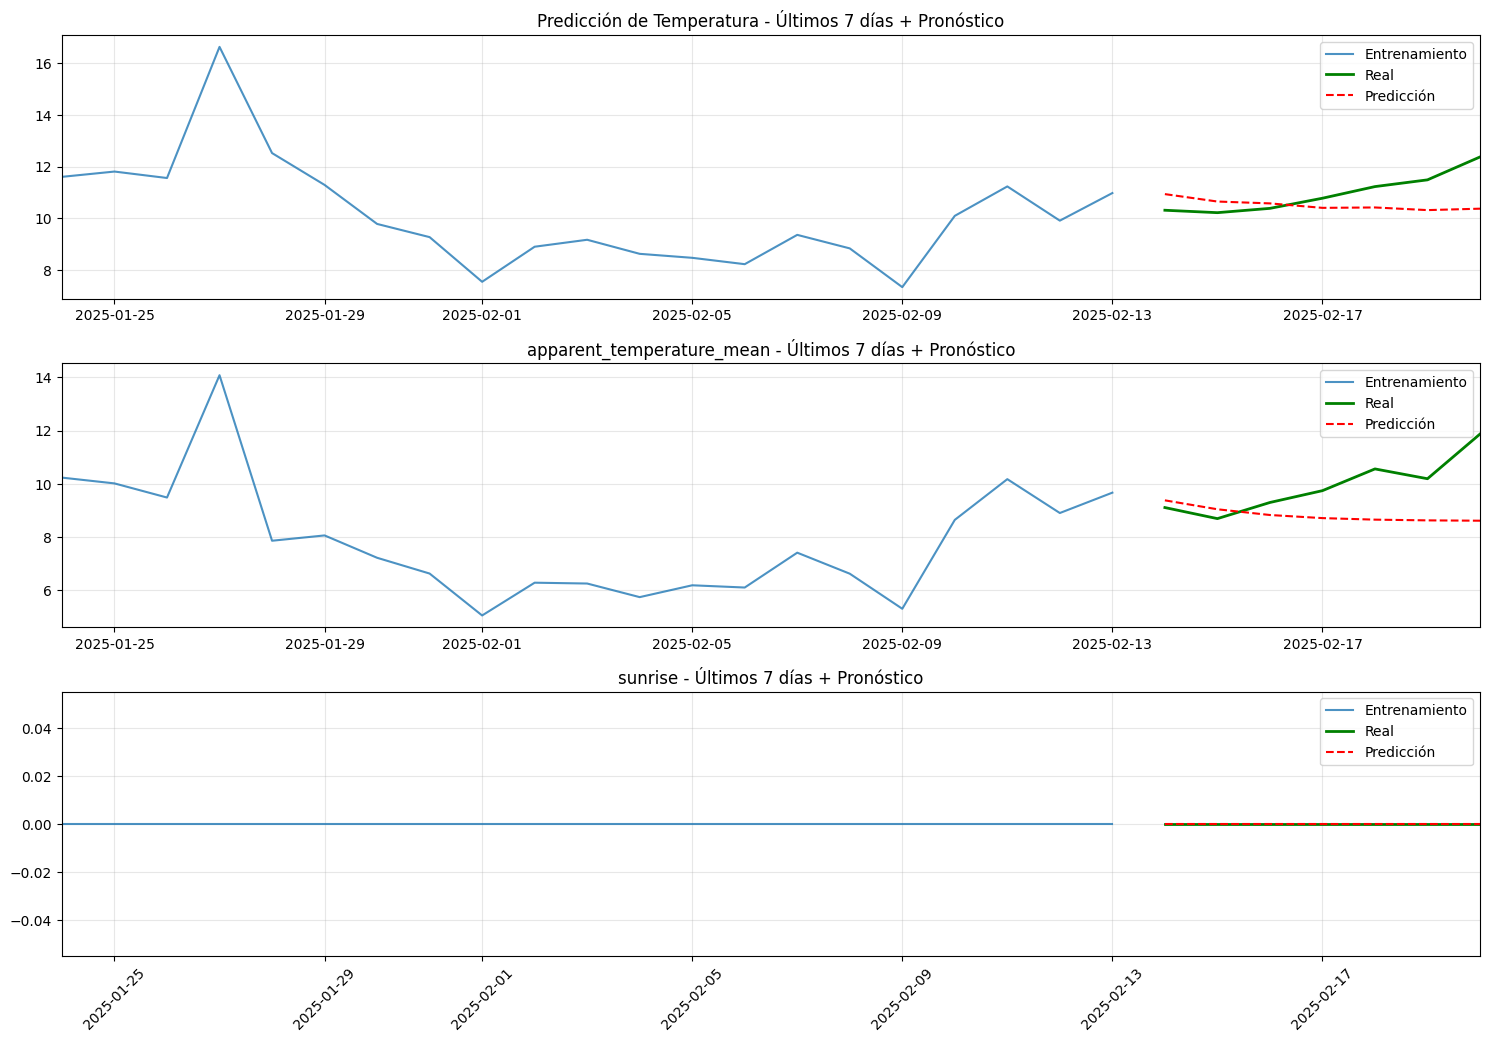

MAE para temperature_2m_mean: 0.80
MAE para apparent_temperature_mean: 1.27
MAE para sunrise: 0.00


In [ ]:
# 2. Manejar valores faltantes
#df = df.interpolate(method='time')
from statsmodels.tsa.arima.model import ARIMA
# 3. Dividir datos (últimos 7 días)
train = df.iloc[:-7]
test = df.iloc[-7:]

# 4. Función para ajustar modelo SARIMAX con parámetros limitados
def fit_sarimax(endog):
    model = auto_arima(
        endog,
        seasonal=False,  # Quitar estacionalidad
        order=(1, 1, 1), # Parámetros más simples
        trace=True
    )
    return model

def fit_quick_model(endog):
    model = ARIMA(endog, order=(0,1,1)).fit()  # Modelo fijo simple
    return model

# 5. Entrenar modelos para cada variable
models = {}
for col in df.columns:
    print(f"\n=== Modelo para {col} ===")
    models[col] = fit_sarimax(train[col])
    print(models[col])

# 6. Predicciones para 24 horas
forecasts = pd.DataFrame(index=pd.date_range(start=test.index[0], periods=7, freq='D'))

for col, model in models.items():
    forecasts[col] = model.predict(n_periods=7)
    print(forecasts[col])

# 7. Visualización
plt.figure(figsize=(15, 10))

start_date = train.index[-21]  #dias para mostrar comparación
end_date = test.index[6]

plt.figure(figsize=(15, 10))

# Temperatura ----
plt.subplot(3,1,1)
# Mostrar solo últimos 3 días de entrenamiento
plt.plot(train['temperature_2m_mean'].last('21D'), label='Entrenamiento', alpha=0.8)
# Test y predicción completos
plt.plot(test['temperature_2m_mean'], label='Real', color='green', linewidth=2)
plt.plot(forecasts['temperature_2m_mean'], label='Predicción', color='red', linestyle='--')
plt.title('Predicción de Temperatura - Últimos 7 días + Pronóstico')
plt.xlim(start_date, end_date)  # Fijar límites temporales
plt.legend()
plt.grid(True, alpha=0.3)

# Humedad ----
plt.subplot(3,1,2)
plt.plot(train['apparent_temperature_mean'].last('21D'), label='Entrenamiento', alpha=0.8)
plt.plot(test['apparent_temperature_mean'], label='Real', color='green', linewidth=2)
plt.plot(forecasts['apparent_temperature_mean'], label='Predicción', color='red', linestyle='--')
plt.title('apparent_temperature_mean - Últimos 7 días + Pronóstico')
plt.xlim(start_date, end_date)
plt.legend()
plt.grid(True, alpha=0.3)

# Precipitación ----
plt.subplot(3,1,3)
plt.plot(train['sunrise'].last('21D'), label='Entrenamiento', alpha=0.8)
plt.plot(test['sunrise'], label='Real', color='green', linewidth=2)
plt.plot(forecasts['sunrise'], label='Predicción', color='red', linestyle='--')
plt.title('sunrise - Últimos 7 días + Pronóstico')
plt.xlim(start_date, end_date)
plt.legend()
plt.grid(True, alpha=0.3)

# Formateo común
plt.tight_layout()
plt.xticks(rotation=45)  # Rotar fechas para mejor visualización
plt.show()


# 8. Métricas de evaluación
from sklearn.metrics import mean_absolute_error

for col in df.columns:
    mae = mean_absolute_error(test[col], forecasts[col])
    print(f'MAE para {col}: {mae:.2f}')